# Step 4: Test the Model
We will now pull our simulation from notebook 2 and our model structure from notebook 3 to ensure that our model is returning the correct results. We use a simulation to do this because we already know what the parameters should be since we used them in the simulation.

For more information on how the simulation, or the model, see the notebooks on Steps 2 and 3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import corner
import math
import statistics
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.lens_plot import lens_model_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
# pretend data
exp_time = 90.
deltaPix = 0.2637
numPix = 46
psf_type = 'GAUSSIAN'
fwhm = 1  # close to our r-band
background_rms = 4  # also close to r-band

In [7]:
# choose parameters (these were chosen for simplicity)
# einstein radius
theta_E = 2

# source position
ra_source = 0.15
dec_source = 0.15

# lens position
center_x = 0
center_y = 0

# ellipticity of the lens
e1 = -0.1
e2 = 0.1

ra_images=[ 2.20302424 -0.59857111 -0.20828818 -0.85046062]
dec_images=[ 0.13380559  1.98518075  2.06261705 -1.46315067]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_57435/2142057254.py:75: RuntimeWarning: invalid value encountered in log10
  ax[0].matshow(np.log10(image_sim), origin='lower')


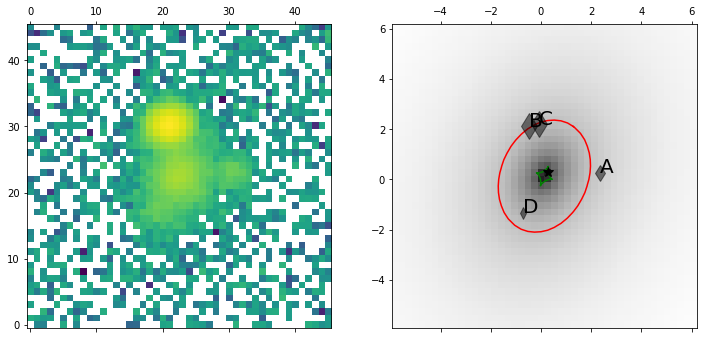

In [8]:
# Simulate data: 
# set data model
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# set the PSF model
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

# Model choices
# LIGHT
light_model_list = ['SERSIC_ELLIPSE']  # choice of light model
lightModel = LightModel(light_model_list=light_model_list)  # set light model class
lens_light = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2,
                'center_x': center_x, 'center_y': center_y, 'e1': e1, 'e2': e2} # set light parameters
kwargs_lens_light = [lens_light]  # if multiple lenses, add multiple {lens_light}s to kwargs_lens_light

# MASS
lens = {'theta_E': theta_E, 'center_x': center_x, 'center_y': center_y, 'e1': e1, 'e2': e2}
kwargs_lens = [lens]  # if multiple lenses, add multiple {lens}s to kwargs_lens
lens_model_list=['SIE']  # choice of mass model
lens_model_class = LensModel(lens_model_list=lens_model_list)  # set lens mass class

# SOURCE
# from our real data, we cannot measure the source position, only the image positions
# so we will calculate image positions from a chosen source here:
lensEquationSolver = LensEquationSolver(lens_model_class)  # set lens equation solver class
source_model_list = light_model_list  # use the same light model for the source
ra_images, dec_images = lensEquationSolver.image_position_from_source(ra_source, dec_source,
                                                                 kwargs_lens, solver='lenstronomy')

print(f'ra_images={ra_images}') # print the image positions in arcsec
print(f'dec_images={dec_images}')


# compute point source magnification
mag = lens_model_class.magnification(ra_images, dec_images, kwargs=kwargs_lens)
point_amp = np.abs(mag)* 100  # convert magnitude to amplitude

# source model
# use LENSED_POSITION for model when using image positions not source position
kwargs_ps = [{'ra_image': ra_images, 'dec_image': dec_images, 'point_amp': point_amp}]
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list,
                                 fixed_magnification_list=[False])

# Image Settings
# numerics
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# combine all classes and settings into Image Model class
imageModel = ImageModel(data_class, psf_class,
                        lens_model_class = lens_model_class,
                        point_source_class=point_source_class,
                        lens_light_model_class=lightModel,
                        kwargs_numerics=kwargs_numerics)

# simulate the image using all our inputs from above
image_sim = imageModel.image(kwargs_lens=kwargs_lens,
                             kwargs_lens_light=kwargs_lens_light,
                             kwargs_ps=kwargs_ps)

# add background noise:
poisson = image_util.add_poisson(image_sim, exp_time=exp_time) 
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms) 
image_sim = image_sim + bkg + poisson  # update image with background noise

# set image data to our simulated image
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

# show image with critical curves and caustics
f, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].matshow(np.log10(image_sim), origin='lower')

# Plot critical curves and caustics
kwargs_lens_plot = {'with_caustics': True, 
                    'fast_caustic': True, 
                    'point_source': True,
                    'with_convergence': True,
                    'numPix': numPix,
                    'deltaPix': deltaPix,
                    'coord_inverse': False} 

lens_model_plot(ax[1],
                lens_model_class, kwargs_lens, 
                sourcePos_x=ra_source,
                sourcePos_y=dec_source,
                **kwargs_lens_plot)

plt.show()
plt.close()

In [9]:
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Two lens positions (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    # make list of distances between center and images
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)
    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E

In [10]:
def model_plot_all_bands_withCC(modelPlot, kwargs_result):
    # get lens model and image positions from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')  # set kwargs
    lensModel = LensModel(lens_model_list=['SIE'])  # set class

    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')

    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]  # set kwargs
    pointSource = PointSource(point_source_type_list=['LENSED_POSITION'], lensModel=lensModel)  # set class

    # find source position from image positions
    x_source_list, y_source_list = lensModel.ray_shooting(x_images, y_images, kwargs_lens_results)
    print(x_source_list)
    print(y_source_list)

    # set up figure
    f, axes = plt.subplots(1, 4, figsize=(20, 5))  # make figure 1x4

    # set row names: names must be in same order as multi_band_list
    axes[0].set_title('Simulation')  # set row title

    # plot observed, reconstructed, and normalized residual plots
    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1], image_names=True)
    modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)

    # check that model is returning physical quantities: 
    check_impos = pointSource.check_image_positions(kwargs_ps_results, kwargs_lens_results, tolerance=0.01)
    check_flux = pointSource.check_positive_flux(kwargs_ps_results)

    print(f'Check Positions: {check_impos}')
    print(f'Check Fluxes: {check_flux}')

    # settings for critical curves and caustics plot
    kwargs_lens_plot = {'with_caustics': True, 
                        'fast_caustic': True, 
                        'point_source': True,
                        'with_convergence': True,
                        'numPix': numPix,
                        'deltaPix': deltaPix,
                        'coord_inverse': False} 

    # plot critical curves and caustics
    lens_model_plot(axes[3], lensModel, 
                    kwargs_lens_results,
                    sourcePos_x=float(x_source_list[0]),  # turn list into float
                    sourcePos_y=float(y_source_list[0]),
                    **kwargs_lens_plot)

    plt.show()
    plt.close()

In [11]:
# MODEL (simplified slightly since the simulation is a single band)
def model(kwargs_lens_initial, kwargs_lens_light_initial, x_images, y_images):
    ## Settings for model
    # model settings defined during simulation, for modeling real images, set models here:
    # lens_model_list = ['SIE']
    # lens_light_model_list = ['SERSIC_ELLIPSE']
    # point_source_list = ['LENSED_POSITION']

    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}

    # numerics was set during simulation, but when modeling from image, set numerics here:                
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    num_images=len(x_images)
    kwargs_constraints = {'num_point_source_list': [num_images]}

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'image_position_uncertainty': 0.01,
                         'check_matched_source_position': True,
                         'check_positive_flux': True,
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.01}

    # with simulation, there is only one band. For real data, add bands here and to multi_band_list
    image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
    multi_band_list = [image_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

    ## Add parameters to model:
    # lens mass
    kwargs_lens_fixed = [{'center_x': center_x, 'center_y': center_y}]  # fixed parameters
    kwargs_lens_init = [kwargs_lens_initial]  # initial input
    kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.01, 'center_y': 0.01}]  # step sizes
    kwargs_lower_lens = [{'theta_E': theta_E - 0.7, 'e1': -0.6, 'e2': -0.6,
                          'center_x': center_x - 0.1, 'center_y': center_y-0.1}]  # lower bounds
    kwargs_upper_lens = [{'theta_E': theta_E + 0.7, 'e1': 0.6, 'e2': 0.6,
                          'center_x': center_x + 0.1, 'center_y': center_y+0.1}]  # upper bounds

    # lens light
    kwargs_lens_light_fixed = [{'center_x': center_x, 'center_y': center_y}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.01, 'center_y': 0.01}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01,
                                'e1': -0.6, 'e2': -0.6,
                                'center_x': center_x-0.1, 'center_y': center_y-0.1}]
    kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 10.,
                                'e1': 0.6, 'e2': 0.6,
                                'center_x': center_x+0.1, 'center_y': center_y+0.1}]

    # point source image positions
    fixed_ps = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_init = [{'ra_image': x_images,'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01] * num_images,
                        'dec_image': [0.01] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.1 for i in x_images],
                        'dec_image': [i-0.1 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.1 for i in x_images],
                        'dec_image': [i+0.1 for i in y_images]}]
    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params}

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints,
                                  kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 400, 'n_iterations': 400}],
                           ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          arrow_size=0.02, cmap_string="gist_heat")

    model_plot_all_bands_withCC(modelPlot, kwargs_result)

    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)


    print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
    print("parameters in order: ", param_mcmc)
    print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)
    plt.show()
    plt.close()

'Estimated theta_E': 2.01
Computing the PSO ...
10
20
30
40
50
60
70
80
90
Converged after 96 iterations!
Best fit found:  -1093.6117930078406 [1.9999757681823578, -0.1000027509444263, 0.10000386775423901, 0.9630843511552835, 1.7501981584852324, -0.09448884867333515, 0.06293464134789659]
-1.03955493631924 reduced X^2 of best position
-1093.6117930078406 logL
2104.0 effective number of data points
[{'theta_E': 1.9999757681823578, 'e1': -0.1000027509444263, 'e2': 0.10000386775423901, 'center_x': 0, 'center_y': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9630843511552835, 'n_sersic': 1.7501981584852324, 'e1': -0.09448884867333515, 'e2': 0.06293464134789659, 'center_x': 0, 'center_y': 0}] lens light result
[{'ra_image': [2.20302424, -0.59857111, -0.20828818, -0.85046062], 'dec_image': [0.13380559, 1.98518075, 2.06261705, -1.46315067], 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
116.75601983070374 time used for  PSO


100%|█████████████████████████████████████████| 800/800 [03:00<00:00,  4.44it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  70
Burn-in iterations:  200
Sampling iterations (in current run): 800
180.52821803092957 time taken for MCMC sampling
-1.0336961805087705 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0336961805087705
[0.15072193 0.1499141  0.15001831 0.14973037]
[0.1500927  0.15095934 0.15098058 0.14907597]
Check Positions: True
Check Fluxes: True


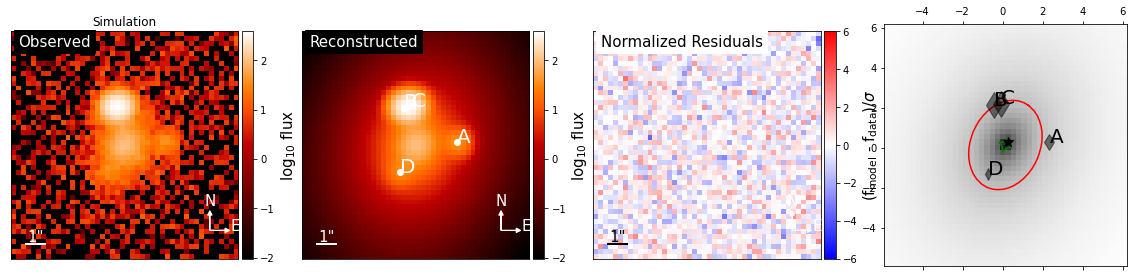

number of non-linear parameters in the MCMC process:  7
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0']
number of evaluations in the MCMC process:  42000
42000


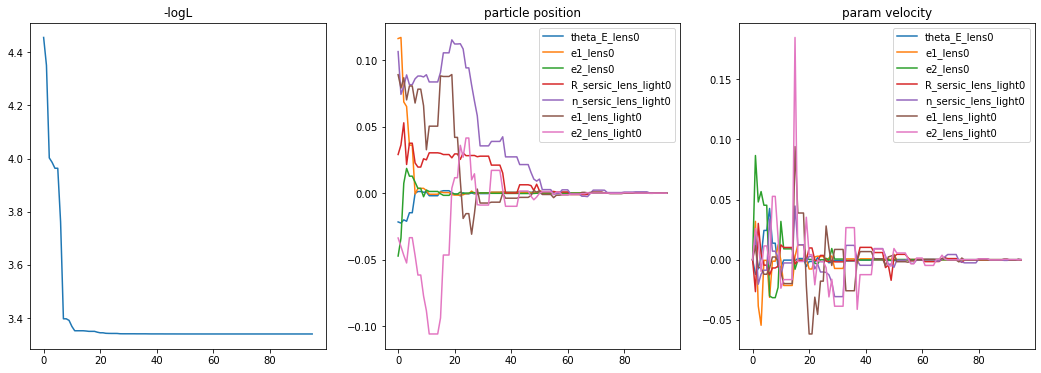

<Figure size 432x288 with 0 Axes>

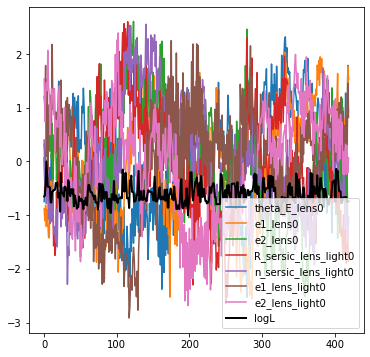

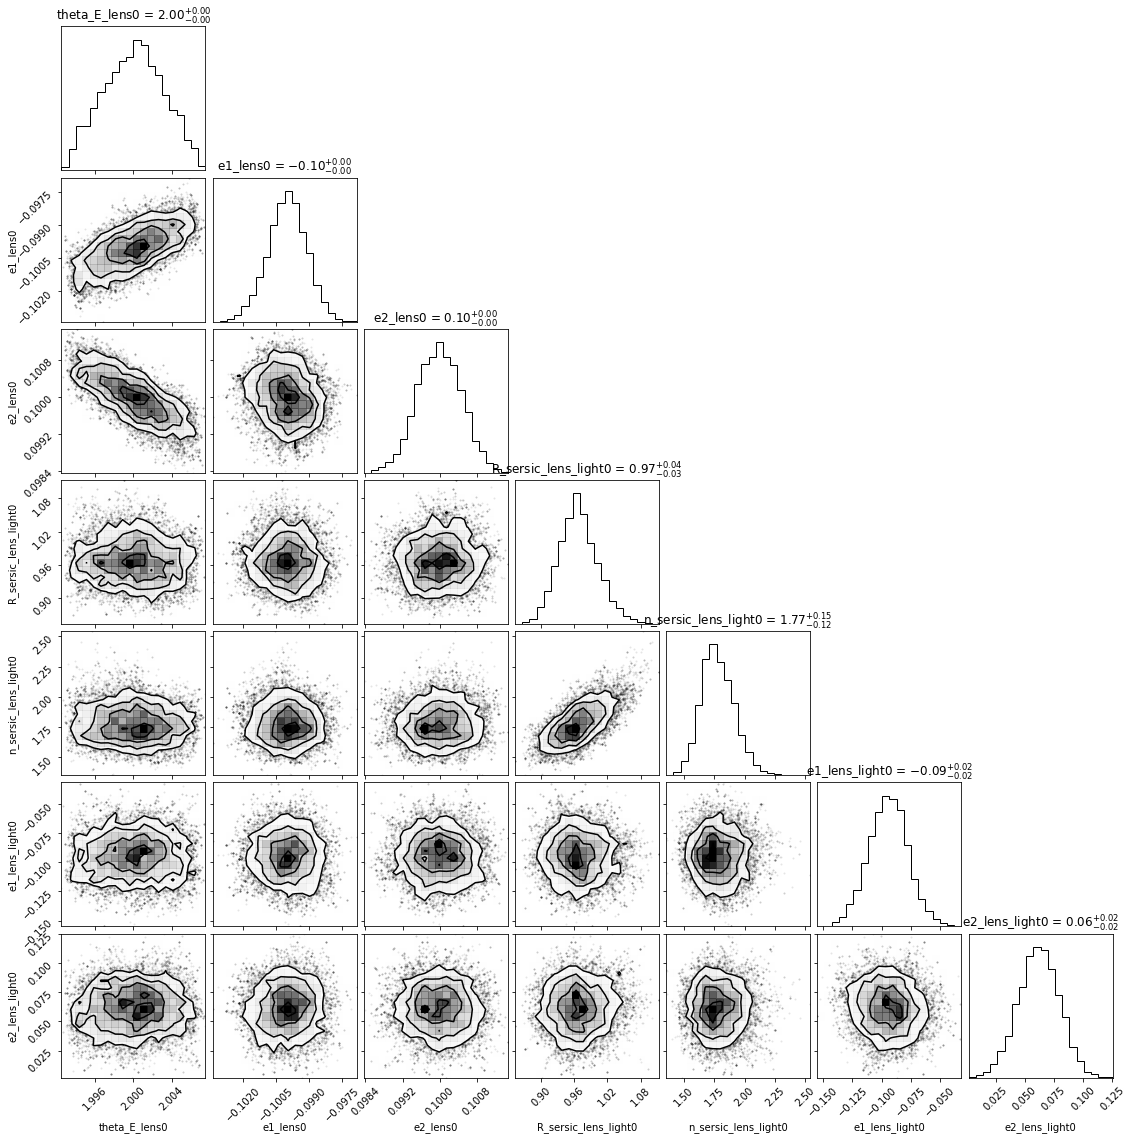

In [14]:
# 'guesses' for image position based on simulation
x_images = [ 2.20302424, -0.59857111, -0.20828818, -0.85046062]
y_images = [ 0.13380559,  1.98518075,  2.06261705, -1.46315067]

# lens position
center_x = 0
center_y = 0

# initial 'guesses' for params
thetaE = approx_theta_E(center_x, center_y, x_images, y_images)  # estimate theta_E

kwargs_lens_initial = {'theta_E': thetaE, 'e1': 0., 'e2': 0.,
                        'center_x': center_x, 'center_y': center_y}

kwargs_lens_light_initial= {'R_sersic': 1., 'n_sersic': 2,
                             'center_x': center_x, 'center_y': center_y,
                             'e1': 0., 'e2': 0.}
# run model
model(kwargs_lens_initial, kwargs_lens_light_initial, x_images, y_images)

### Done! The checks are both true (check positive flux and check image positions) and the model is returning similar results to what we input into the simulation. Now that we know the model is working, we can move onto notebook 5, modeling real data.